#  Neural Style Transfer

In [1]:
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
class CONFIG:
    IMAGE_WIDTH = 712
    IMAGE_HEIGHT = 474
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    
    
def load_vgg_model(path):
    
    
    
#     https://in.mathworks.com/help/deeplearning/ref/vgg19.html
    """"
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)
#     print(vgg.keys())
    print(vgg['layers'].shape)
#     print(vgg.shape)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        
        wb = vgg_layers[0][layer][0][0][2]
        print(vgg_layers[0][layer].shape)
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b


    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        print(W.shape,b.shape)
        
        return tf.nn.conv2d(prev_layer, filters=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    
#     Now, we initialize the "generated" image as a noisy image created from the content_image. By initializing the pixels of the
#     generated image to be mostly noise but still slightly correlated with the content image, this will help the content of the
#     "generated" image more rapidly match the content of the "content" image.
    noise_image = np.random.uniform(-20, 20, (1,content_image.shape[1],content_image.shape[2],content_image.shape[3] )).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image


def reshape_and_normalize_image(image):
    
    image = np.reshape(image, ((1,) + image.shape))
    print(image.shape)
    image = image - CONFIG.MEANS
    
    return image


def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    plt.imsave(path, image)


We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 


(400, 300, 3)


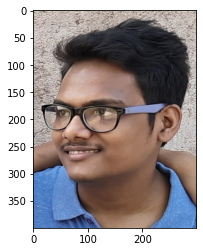

In [3]:
content_image = plt.imread("images/c_i.jpeg")
imshow(content_image)
print(content_image.shape)
CONFIG.IMAGE_WIDTH=content_image.shape[1]
CONFIG.IMAGE_HEIGHT=content_image.shape[0]
CONFIG.COLOR_CHANNELS=content_image.shape[2]

In [4]:
def compute_content_cost(a_C, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    print(a_C.shape)
    print(a_G.shape)
    a_C_unrolled = tf.reshape(a_C, shape = [m, n_H, n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape = [m, n_H, n_W, n_C])
    print(a_C.shape)
    print(a_G.shape)
    print(a_G_unrolled)
    print(a_C_unrolled)
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    
    return J_content

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

(1, 4, 4, 3)
(1, 4, 4, 3)
(1, 4, 4, 3)
(1, 4, 4, 3)
Tensor("Reshape_1:0", shape=(1, 4, 4, 3), dtype=float32)
Tensor("Reshape:0", shape=(1, 4, 4, 3), dtype=float32)
J_content = 6.7655926


### Computing the style cost



(400, 300, 3)


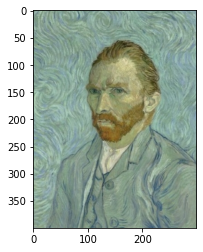

In [6]:
style_image = plt.imread("images/style.jpeg")
print(style_image.shape)
imshow(style_image)

In [7]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


###  Style cost


$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  


In [9]:
def compute_layer_style_cost(a_S, a_G):

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(a_S, shape = [n_H * n_W, n_C])
    a_G = tf.reshape(a_G, shape = [n_H * n_W, n_C])

    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

    J_style_layer = (tf.reduce_sum(tf.square(GS - GG)))/(4 * n_C**2 * (n_H * n_W)**2)
    
    
    return J_style_layer

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190278


In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [12]:
def compute_style_cost(model, STYLE_LAYERS):
   
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]

        a_S = sess.run(out)

        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

### 3.3 - Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$



In [13]:
def total_cost(J_content, J_style, alpha = 10000, beta = 20000):
    J = alpha * J_content + beta * J_style
    return J

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 26616.481744542973


In [15]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [16]:
content_image = plt.imread("images/c_i.jpeg")
print(content_image.shape)
content_image = reshape_and_normalize_image(content_image)   # doing a/c to vgg requirement
print(content_image.shape)

(400, 300, 3)
(1, 400, 300, 3)
(1, 400, 300, 3)


In [17]:
style_image = plt.imread("images/style.jpeg")
print(style_image.shape)
style_image = reshape_and_normalize_image(style_image)
print(style_image.shape)

(400, 300, 3)
(1, 400, 300, 3)
(1, 400, 300, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


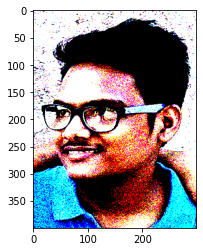

In [18]:
# print(content_image.shape)
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [19]:
# VGG19
# So in simple language VGG is a deep CNN used to classify images. The layers in VGG19 model are as follows:
# input
# Conv3x3 (64)
# Conv3x3 (64)
# MaxPool
# Conv3x3 (128)
# Conv3x3 (128)
# MaxPool
# Conv3x3 (256)
# Conv3x3 (256)
# Conv3x3 (256)
# Conv3x3 (256)
# MaxPool
# Conv3x3 (512)
# Conv3x3 (512)
# Conv3x3 (512)
# Conv3x3 (512)
# MaxPool
# Conv3x3 (512)
# Conv3x3 (512)
# Conv3x3 (512)
# Conv3x3 (512)
# MaxPool
# Fully Connected (4096)
# Fully Connected (4096)
# Fully Connected (1000)
# SoftMax
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

(1, 43)
(1, 1)
(3, 3, 3, 64) (64,)
(1, 1)
(3, 3, 64, 64) (64,)
(1, 1)
(3, 3, 64, 128) (128,)
(1, 1)
(3, 3, 128, 128) (128,)
(1, 1)
(3, 3, 128, 256) (256,)
(1, 1)
(3, 3, 256, 256) (256,)
(1, 1)
(3, 3, 256, 256) (256,)
(1, 1)
(3, 3, 256, 256) (256,)
(1, 1)
(3, 3, 256, 512) (512,)
(1, 1)
(3, 3, 512, 512) (512,)
(1, 1)
(3, 3, 512, 512) (512,)
(1, 1)
(3, 3, 512, 512) (512,)
(1, 1)
(3, 3, 512, 512) (512,)
(1, 1)
(3, 3, 512, 512) (512,)
(1, 1)
(3, 3, 512, 512) (512,)
(1, 1)
(3, 3, 512, 512) (512,)


In [20]:
sess.run(model['input'].assign(content_image))

out = model['conv1_2']

a_C = sess.run(out)
print(a_C)
print('aaaafsadf')
a_G = out
print(a_G)

J_content = compute_content_cost(a_C, a_G)

[[[[6.00259033e+02 9.05152893e+01 3.80224347e-01 ... 5.50750809e+01
    2.60924744e+02 1.46932877e+02]
   [6.73714066e+01 6.89167252e+01 8.71547012e+01 ... 8.63052521e+01
    2.30745743e+02 1.33493866e+02]
   [0.00000000e+00 0.00000000e+00 8.44509888e+01 ... 4.39882317e+01
    1.15702805e+02 6.82343369e+01]
   ...
   [2.01630280e+02 1.27395416e+02 6.80062561e+01 ... 9.12982178e+01
    4.36550140e+01 5.40669632e+01]
   [1.50008636e+02 9.94563961e+00 7.74418259e+01 ... 5.89816551e+01
    1.49435104e+02 1.54921158e+02]
   [0.00000000e+00 0.00000000e+00 1.70737152e+01 ... 4.74816399e+01
    0.00000000e+00 9.67121506e+01]]

  [[1.00508316e+02 4.68770485e+01 9.46314545e+01 ... 8.41344681e+01
    2.02416367e+02 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.40949936e+02 ... 5.82786827e+01
    2.77731384e+02 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.12934189e+02 ... 6.64730597e+00
    2.56383881e+02 8.05768204e+01]
   ...
   [6.55129166e+01 8.78685284e+00 2.18277573e+02 ... 1.39

In [21]:
sess.run(model['input'].assign(style_image))

J_style = compute_style_cost(model, STYLE_LAYERS)

In [22]:
J = total_cost(J_content, J_style, alpha = 20, beta = 60)

In [23]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [24]:
def model_nn(sess, input_image, num_iterations = 2000):
    
    sess.run(tf.global_variables_initializer())
    
    sess.run(model["input"].assign(input_image))
    
    for i in range(num_iterations):
        sess.run(train_step)
        generated_image = sess.run(model['input'])
    
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            save_image("output/" + str(i) + ".png", generated_image)
    
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [25]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 559257300.0
content cost = 2758.733
style cost = 9320035.0
Iteration 20 :
total cost = 50199800.0
content cost = 3207.0295
style cost = 835594.3


KeyboardInterrupt: 

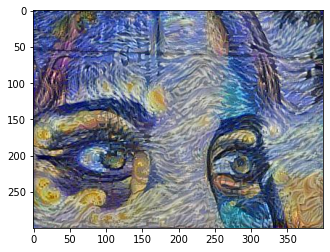

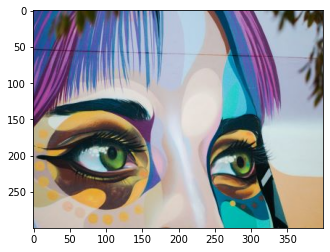

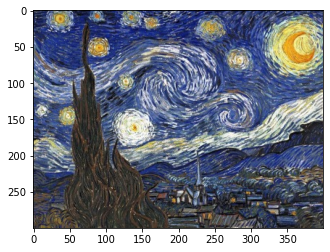

In [233]:
imshow(plt.imread('output/generated_image.jpg'))
plt.show()
imshow(plt.imread('images/c_i.jpg'))
plt.show()
imshow(plt.imread('images/style.jpg'))